# Multimodal LLMs - Easy Tasks

Basic concepts with CLIP and BLIP-2. Loading models, making embeddings, simple image tasks.

**Topics:**
- CLIP text/image embeddings
- Computing similarity scores
- Basic image captioning
- Simple visual Q&A

## Setup

Run all cells in this section.

### [Optional] - Installing Packages on Google Colab

If you are viewing this notebook on Google Colab, uncomment and run the following code to install dependencies.

**Note**: Use a GPU for this notebook. In Google Colab, go to Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4.

In [1]:
# %%capture
!pip install matplotlib transformers datasets accelerate sentence-transformers pillow torchvision

### Import Libraries

In [2]:
from urllib.request import urlopen
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
from transformers import AutoProcessor, Blip2ForConditionalGeneration

print("Imports ready")

Imports ready


### Load Sample Images

We'll use a few AI-generated images for testing.

In [3]:
# Image URLs
puppy = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png"
cat = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/cat.png"
car = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"

print("Image URLs loaded")

Image URLs loaded


## Easy Tasks

Basic operations with multimodal models.

### Task 1: CLIP Text Embeddings

Create embeddings for text using CLIP. Text embeddings capture semantic meaning.

**Goal**: Embed a caption and inspect the result.

In [4]:
# Load CLIP model
model_id = "openai/clip-vit-base-patch32"
print("Loading CLIP...")

clip_tok = CLIPTokenizerFast.from_pretrained(model_id)
clip_proc = CLIPProcessor.from_pretrained(model_id)
clip_model = CLIPModel.from_pretrained(model_id)

print("Loaded")

Loading CLIP...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Loaded


In [5]:
# Tokenize text
caption = "a puppy playing in the snow"

inputs = clip_tok(caption, return_tensors="pt")
print(f"Caption: {caption}")

Caption: a puppy playing in the snow


In [6]:
# Check tokens
tokens = clip_tok.convert_ids_to_tokens(inputs["input_ids"][0])
print(f"Tokens: {tokens}")

Tokens: ['<|startoftext|>', 'a</w>', 'puppy</w>', 'playing</w>', 'in</w>', 'the</w>', 'snow</w>', '<|endoftext|>']


In [7]:
# Create text embedding
txt_emb = clip_model.get_text_features(**inputs)

print(f"Embedding shape: {txt_emb.shape}")
print(f"First 5 values: {txt_emb[0][:5].tolist()}")

Embedding shape: torch.Size([1, 512])
First 5 values: [-0.2120274007320404, -0.16565310955047607, -0.17938272655010223, 0.01107139140367508, -0.0953136682510376]


**Questions:**

1. Try a different caption - how does the embedding change?
2. What happens with very long text?
3. Try text in another language - does it work?

### Task 2: CLIP Image Embeddings

Same idea but for images. Images get processed into patches, then embedded.

**Goal**: Load an image, embed it, check the shape.

In [8]:
# Load image
img = Image.open(urlopen(puppy)).convert("RGB")

print(f"Loaded image")
print(f"Size: {img.size}")

Loaded image
Size: (512, 512)


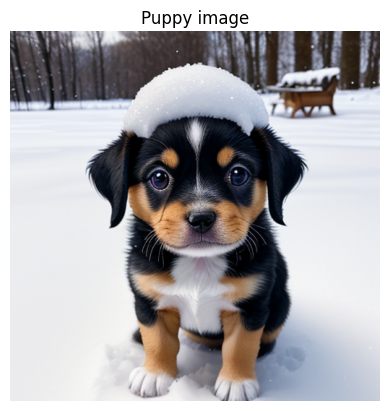

In [9]:
# Show image
plt.imshow(img)
plt.axis('off')
plt.title("Puppy image")
plt.show()

In [10]:
# Preprocess
proc_img = clip_proc(
    text=None,
    images=img,
    return_tensors='pt'
)['pixel_values']

print(f"Processed shape: {proc_img.shape}")

Processed shape: torch.Size([1, 3, 224, 224])


In [11]:
# Original was probably different size
print(f"Original: {img.size}")
print(f"After processing: 224x224 (required by CLIP)")

Original: (512, 512)
After processing: 224x224 (required by CLIP)


In [12]:
# Create image embedding
img_emb = clip_model.get_image_features(proc_img)

print(f"Image embedding shape: {img_emb.shape}")
print(f"Same as text? {img_emb.shape == txt_emb.shape}")

Image embedding shape: torch.Size([1, 512])
Same as text? True


**Questions:**

1. Load the cat or car image - what's different?
2. Why does CLIP resize to 224x224?
3. What happens if you load a very small image?

### Task 3: Text-Image Similarity

Compare embeddings to see if image matches caption.

**Goal**: Calculate similarity score between text and image.

In [13]:
# Normalize embeddings (required for cosine similarity)
txt_emb = txt_emb / txt_emb.norm(dim=-1, keepdim=True)
img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)

print("Normalized embeddings")

Normalized embeddings


In [14]:
# Calculate similarity
txt_np = txt_emb.detach().cpu().numpy()
img_np = img_emb.detach().cpu().numpy()

sim = txt_np @ img_np.T

print(f"Similarity: {sim[0][0]:.4f}")

Similarity: 0.3315


In [15]:
# Try wrong caption
wrong = "a car driving at sunset"
wrong_inp = clip_tok(wrong, return_tensors="pt")

wrong_emb = clip_model.get_text_features(**wrong_inp)
wrong_emb = wrong_emb / wrong_emb.norm(dim=-1, keepdim=True)

wrong_np = wrong_emb.detach().cpu().numpy()
sim_wrong = wrong_np @ img_np.T

print(f"\nCorrect caption: {sim[0][0]:.4f}")
print(f"Wrong caption: {sim_wrong[0][0]:.4f}")


Correct caption: 0.3315
Wrong caption: 0.1362


**Questions:**

1. Try other caption variations - which scores highest?
2. What's a "good" similarity score?
3. Can you find a caption that scores even lower?

### Task 4: Zero-Shot Image Classification

Use CLIP to classify images without training. Just compare image to class descriptions.

**Goal**: Given an image, find which class description matches best.

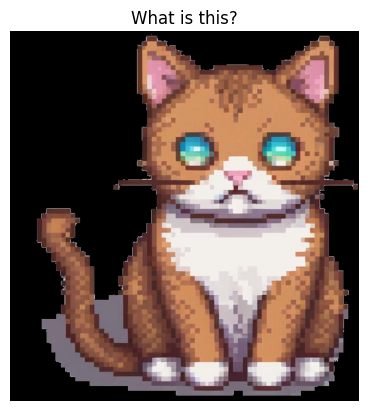

In [16]:
# Load cat image
cat_img = Image.open(urlopen(cat)).convert("RGB")

plt.imshow(cat_img)
plt.axis('off')
plt.title("What is this?")
plt.show()

In [17]:
# Possible classes
classes = [
    "a photo of a dog",
    "a photo of a cat",
    "a photo of a car",
    "a photo of a bird"
]

print("Classes:")
for i, c in enumerate(classes, 1):
    print(f"{i}. {c}")

Classes:
1. a photo of a dog
2. a photo of a cat
3. a photo of a car
4. a photo of a bird


In [18]:
# Embed image
cat_proc = clip_proc(images=cat_img, return_tensors='pt')['pixel_values']
cat_emb = clip_model.get_image_features(cat_proc)
cat_emb = cat_emb / cat_emb.norm(dim=-1, keepdim=True)

print("Image embedded")

Image embedded


In [19]:
# Embed all classes
class_embs = []

for cls in classes:
    inp = clip_tok(cls, return_tensors="pt")
    emb = clip_model.get_text_features(**inp)
    emb = emb / emb.norm(dim=-1, keepdim=True)
    class_embs.append(emb)

print(f"Embedded {len(class_embs)} classes")

Embedded 4 classes


In [20]:
# Calculate similarities
cat_np = cat_emb.detach().cpu().numpy()
scores = []

for emb in class_embs:
    emb_np = emb.detach().cpu().numpy()
    sc = cat_np @ emb_np.T
    scores.append(sc[0][0])

print("\nScores:")
for cls, sc in zip(classes, scores):
    print(f"{cls}: {sc:.4f}")


Scores:
a photo of a dog: 0.2143
a photo of a cat: 0.2621
a photo of a car: 0.1618
a photo of a bird: 0.1778


In [21]:
# Find best match
best_idx = np.argmax(scores)
best_class = classes[best_idx]

print(f"\nPrediction: {best_class}")
print(f"Confidence: {scores[best_idx]:.4f}")


Prediction: a photo of a cat
Confidence: 0.2621


**Questions:**

1. Try the car image - does it classify correctly?
2. Add more classes - does accuracy drop?
3. What if you use very specific class names?

### Task 5: Basic Image Captioning with BLIP-2

Generate text descriptions of images. BLIP-2 bridges vision and language.

**Goal**: Load an image, generate a caption.

In [22]:
from huggingface_hub import snapshot_download
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import os
import time
import torch

# Set longer timeout
os.environ['HF_HUB_DOWNLOAD_TIMEOUT'] = '300'

# Try pre-downloading the model first
print("Pre-downloading model files...")
snapshot_download(
    "Salesforce/blip2-opt-2.7b",
    revision="51572668da0eb669e01a189dc22abe6088589a24",
    resume_download=True
)

# Load processor and main model
blip_proc = AutoProcessor.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    revision="51572668da0eb669e01a189dc22abe6088589a24"  # Choose specific model because of: https://huggingface.co/Salesforce/blip2-opt-2.7b/discussions/39
)
blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    revision="51572668da0eb669e01a189dc22abe6088589a24",
    torch_dtype=torch.float16,
)

# Fix for missing bos_token_id and image_token_index in model config, as suggested in Hugging Face discussions
if blip_model.config.text_config.bos_token_id is None:
    blip_model.config.text_config.bos_token_id = blip_proc.tokenizer.bos_token_id
if blip_model.config.image_token_index is None:
    blip_model.config.image_token_index = blip_proc.tokenizer.convert_tokens_to_ids('<image>')

# Send the model to GPU to speed up inference
dev = "cuda" if torch.cuda.is_available() else "cpu"
blip_model.to(dev)

print(f"BLIP-2 loaded successfully on {dev}")


Pre-downloading model files...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

BLIP-2 loaded successfully on cuda


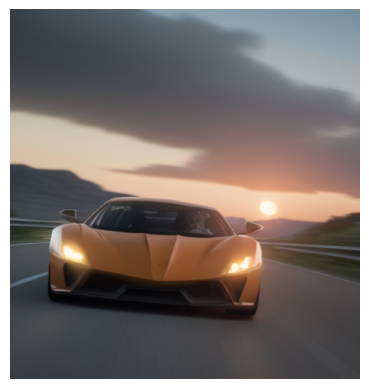

In [23]:
# Load car image
car_img = Image.open(urlopen(car)).convert("RGB")

plt.imshow(car_img)
plt.axis('off')
plt.show()

In [24]:
# Preprocess
inp = blip_proc(car_img, return_tensors="pt").to(dev, torch.float16)

print("Image preprocessed")
print(f"Shape: {inp['pixel_values'].shape}")

Image preprocessed
Shape: torch.Size([1, 3, 224, 224])


In [25]:
# Generate caption
gen_ids = blip_model.generate(**inp, max_new_tokens=20)

caption = blip_proc.batch_decode(gen_ids, skip_special_tokens=True)
caption = caption[0].strip()

print(f"Caption: {caption}")

Caption: an orange supercar driving on the road at sunset


In [26]:
# Try with puppy
pup_img = Image.open(urlopen(puppy)).convert("RGB")

inp = blip_proc(pup_img, return_tensors="pt").to(dev, torch.float16)
gen_ids = blip_model.generate(**inp, max_new_tokens=20)
caption = blip_proc.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()

print(f"Puppy caption: {caption}")

Puppy caption: a puppy wearing a snow hat in the snow


**Questions:**

1. Try your own images - how accurate are captions?
2. What happens with abstract or artistic images?
3. Increase max_new_tokens to 50 - do captions get better?

### Task 6: Simple Visual Q&A

Ask questions about images. Model processes both image and question.

**Goal**: Give BLIP-2 an image and a question, get an answer.

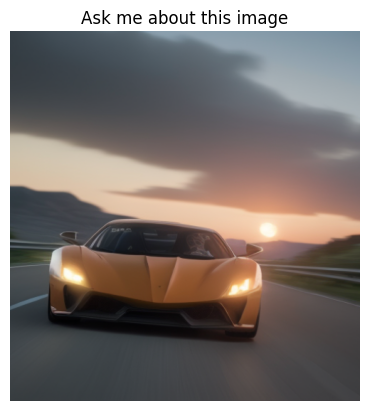

In [27]:
# Load car image again
car_img = Image.open(urlopen(car)).convert("RGB")

plt.imshow(car_img)
plt.axis('off')
plt.title("Ask me about this image")
plt.show()

In [28]:
# Ask a question
q = "Question: What color is the car? Answer:"

inp = blip_proc(car_img, text=q, return_tensors="pt")
inp = inp.to(dev, torch.float16)

print(f"Question: {q}")

Question: Question: What color is the car? Answer:


In [29]:
# Generate answer
gen_ids = blip_model.generate(**inp, max_new_tokens=20)
ans = blip_proc.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()

print(f"Answer: {ans}")

Answer: Question: What color is the car? Answer: It's a fucking black car.


In [30]:
# Try another question
q2 = "Question: Is this indoors or outdoors? Answer:"

inp = blip_proc(car_img, text=q2, return_tensors="pt")
inp = inp.to(dev, torch.float16)

gen_ids = blip_model.generate(**inp, max_new_tokens=20)
ans2 = blip_proc.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()

print(f"Q: {q2}")
print(f"A: {ans2}")

Q: Question: Is this indoors or outdoors? Answer:
A: Question: Is this indoors or outdoors? Answer: Indoor.


**Questions:**

1. Try yes/no questions - does it answer correctly?
2. Ask about details not in the image - what happens?
3. What types of questions work best?